<a href="https://colab.research.google.com/github/Nam-gu/MLB_Prediction/blob/main/70%ED%8D%BC%ED%99%95%EC%9D%B8%EC%A2%80%EC%9A%94.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn import metrics
import statsmodels.api as sm
from sklearn.metrics import accuracy_score
import lightgbm
from lightgbm import LGBMClassifier
from sklearn import svm
from sklearn.preprocessing import StandardScaler
import warnings
import argparse
warnings.filterwarnings('ignore')

alpha = 0.1
min_periods=1
def sigma(alpha, period):
    r = 1-alpha
    return (r**(period)-1)/(r-1)


from google.colab import drive
drive.mount('/content/drive')

base=['NYY', 'MIN', 'CLE', 'DET', 'SEA', 'TOR', 'SD', 'CHC', 'STL', 'SF', 'COL', 'MIA',
 'LAD', 'PHI' ,'BAL', 'OAK', 'BOS', 'PIT', 'WAS', 'ATL' ,'TB', 'TEX' ,'KC' ,'CWS',
 'MIL', 'CIN' ,'HOU', 'LAA', 'NYM', 'ARI']

file = 'drive/MyDrive/data/Retrosheet_2010_2019/1980_to_2019_seasons.csv'
game_df = pd.read_csv(file)

game_col_del = '''VisitorGDP,VisitorCI,HomeGDP,HomeCI, DoubleHeader, DayOfWeek, VisitingTeamLeague, HomeTeamLeague, DayNight, CompletionInfo,ForfeitInfo, ProtestInfo,Duration, VisitorLineScore, HomeLineScore, UmpireHID, UmpireHName, Umpire1BID, Umpire1BName, Umpire2BID,Umpire2BName, Umpire3BID, Umpire3BName, UmpireLFID, UmpireLFName, UmpireRFID,UmpireRFName, VisitorManagerID, VisitorManagerName, HomeManagerID, HomeManagerName,WinningPitcherID, WinningPitcherName, LosingPitcherID, LosingPitcherNAme,SavingPitcherID, SavingPitcherName, GameWinningRBIID, GameWinningRBIName, VisitorBatting1Position, VisitorBatting2Position, VisitorBatting3Position,VisitorBatting4Position, VisitorBatting5Position, VisitorBatting6Position,VisitorBatting7Position, VisitorBatting8Position, VisitorBatting9Position,HomeBatting1Position, HomeBatting2Position, HomeBatting3Position,HomeBatting4Position, HomeBatting5Position, HomeBatting6Position,HomeBatting7Position, HomeBatting8Position, HomeBatting9Position,AdditionalInfo, AcquisitionInfo'''
game_col_del = game_col_del.replace(" ", "")
game_col_del = game_col_del.split(",")

game_df.drop(game_col_del,axis=1,inplace=True)




my_attendence={'BOS':37755, 'LAA':45517, 'CWS':40615, 'KC':37903, 'OAK':56782, 'TEX':40300, 'ARI':48686, 'ATL':41084, 'CIN':42319,
       'HOU':41168, 'MIL':41900, 'NYM':41922, 'PIT':38747, 'WAS':41339, 'TB':42735, 'BAL':44970, 'DET':41083, 'COL':50144,
       'MIA':37442, 'SF':41265, 'CLE':34830, 'MIN':38544, 'SEA':47929, 'TOR':49282, 'CHC':41649, 'PHI':42792, 'SD':40209, 'STL':45494,
       'NYY':54251, 'LAD':56000}
# Had an extra team due to the Marlins having two different labels. Updating their team name to MIA

game_df.replace(to_replace='FLO', value='MIA', inplace=True)

# Updating game_df so team abbreviations match. Will be leveraged when aggregating teams stats
game_df.replace(to_replace={"NYA":"NYY", "SDN":"SD", "CHN":"CHC", "SLN":"STL", "SFN":"SF", "LAN":"LAD", "TBA":"TB", "KCA":"KC", "CHA":"CWS", "ANA":"LAA", "NYN":"NYM"}, inplace=True)



# totalname=set(game_df['VisitingTeam'].unique())
# print(len(totalname))
# print(len(base))
# base=set(base)
# exceptname=totalname - base
# print(exceptname)
# input()
# print(ttt)

#{'MON', 'CAL'} 빼야 하는 팀

indexNames = game_df[ game_df['VisitingTeam'] == 'MON' ].index
# Delete these row indexes from dataFrame
game_df.drop(indexNames , inplace=True)
indexNames = game_df[ game_df['VisitingTeam'] == 'CAL' ].index
# Delete these row indexes from dataFrame
game_df.drop(indexNames , inplace=True)
indexNames = game_df[ game_df['HomeTeam'] == 'MON' ].index
# Delete these row indexes from dataFrame
game_df.drop(indexNames , inplace=True)
indexNames = game_df[ game_df['HomeTeam'] == 'CAL' ].index
# Delete these row indexes from dataFrame
game_df.drop(indexNames , inplace=True)

for key, value in my_attendence.items():
  game_df.loc[game_df['HomeTeam']==key,'Attendence']=game_df.loc[game_df['HomeTeam']==key,'Attendence']/value


file4 = 'drive/MyDrive/data/park_factors.csv'
parkfactor_df = pd.read_csv(file4, encoding='cp949')
parkfactor_df

# Had an extra team due to the Marlins having two different labels. Updating their team name to MIA
parkfactor_df.replace(to_replace='FLO', value='MIA', inplace=True)

# Updating game_df so team abbreviations match. Will be leveraged when aggregating teams stats
parkfactor_df.replace(to_replace={"NYA":"NYY", "SDN":"SD", "CHN":"CHC", "SLN":"STL", "SFN":"SF", "LAN":"LAD", "TBA":"TB", "KCA":"KC", "CHA":"CWS", "ANA":"LAA", "NYN":"NYM"}, inplace=True)


game_df = pd.merge(game_df, parkfactor_df, on="HomeTeam")

col_del = ['VisitorBatting1PlayerID', 'VisitorBatting1Name', 'VisitorBatting2PlayerID', 'VisitorBatting2Name', 'VisitorBatting3PlayerID', 'VisitorBatting3Name', 'VisitorBatting4PlayerID', 'VisitorBatting4Name', 'VisitorBatting5PlayerID', 'VisitorBatting5Name', 'VisitorBatting6PlayerID', 'VisitorBatting6Name', 'VisitorBatting7PlayerID', 'VisitorBatting7Name', 'VisitorBatting8PlayerID', 'VisitorBatting8Name', 'VisitorBatting9PlayerID', 'VisitorBatting9Name', 'HomeBatting1PlayerID', 'HomeBatting1Name', 'HomeBatting2PlayerID', 'HomeBatting2Name', 'HomeBatting3PlayerID', 'HomeBatting3Name', 'HomeBatting4PlayerID', 'HomeBatting4Name', 'HomeBatting5PlayerID', 'HomeBatting5Name', 'HomeBatting6PlayerID', 'HomeBatting6Name', 'HomeBatting7PlayerID', 'HomeBatting7Name', 'HomeBatting8PlayerID', 'HomeBatting8Name', 'HomeBatting9PlayerID', 'HomeBatting9Name']
game_df.drop(col_del,axis=1,inplace=True)
game_df = game_df.rename(columns={"VisitingTeam":"VisitorTeam","VisitingTeamGameNumber":"VisitorTeamGameNumber"})

game_df['Date'] = pd.to_datetime(game_df['Date'].astype(str), format='%Y%m%d')
game_df['current_year'] = game_df['Date'].dt.year

game_df['prior_year']=game_df['current_year']-1
print(game_df.Attendence)

trend=1 #몇일 롤링

game_df['home_attendance'] = game_df.groupby(['current_year', 'HomeTeam'])['Attendence'].transform(lambda x: round(x.rolling(trend).mean().shift(periods=1, axis=0), 3))


away_inning = game_df['LengthInOuts']//2
home_inning = game_df['LengthInOuts']- away_inning


game_df['VisitorOffInn'] = away_inning
game_df['VisitorDifInn'] = home_inning
game_df['HomeOffInn'] = home_inning
game_df['HomeDifInn'] = away_inning

game_df['Home_team_won?'] = game_df['HomeRunsScore'] > game_df['VisitorRunsScored']
game_df['Visitor_team_won?'] = game_df['HomeRunsScore'] < game_df['VisitorRunsScored']

bat_stat = [ 'TeamGameNumber','Team','AB','H','D','T','HR','RBI','SH','SF',
'HBP','BB','IBB','K','SB','CS','LOB','Pitchers',
'ER','TER','WP','Balks','PO','A','E','Passed','DB','TP','OffInn','DifInn','_team_won?']
pit_stat = ['H', 'D', 'T', 'HR', 'RBI', 'SH', 'SF', 'HBP', 'BB', 'IBB', 'K', 'LOB', 'ER','DB','AB']

select_stat = ['Date']
select_stat += ['Home'+i for i in bat_stat]+['Visitor'+i for i in pit_stat]
rename1 = {'Visitor'+i:'Pit'+i for i in pit_stat}
rename2 = {'Home'+i:i for i in bat_stat}

## Home 시각 
select_stat = ['Date']
select_stat += ['Home'+i for i in bat_stat]+['Visitor'+i for i in pit_stat]
rename1 = {'Visitor'+i:'Pit'+i for i in pit_stat}
rename2 = {'Home'+i:i for i in bat_stat}
Home = game_df.copy()
Home = Home[select_stat].rename(columns=rename1)
Home = Home.rename(columns=rename2)
# away 시각
select_stat = ['Date']
select_stat += ['Visitor'+i for i in bat_stat]+['Home'+i for i in pit_stat]
rename1 = {'Home'+i:'Pit'+i for i in pit_stat}
rename2 = {'Visitor'+i:i for i in bat_stat}
Visitor = game_df.copy()
Visitor = Visitor[select_stat].rename(columns=rename1)
Visitor = Visitor.rename(columns=rename2)

sep_team = pd.concat([Home,Visitor])
sep_team = sep_team.sort_values(['Date','TeamGameNumber'],ascending=True)
sep_team = sep_team.reset_index(drop=True)

sep_team = sep_team.rename(columns={'PitDB':'DP'})
sep_team

col = ['AB', 'H', 'D', 'T', 'HR', 'RBI','DP',
       'SF', 'BB', 'K', 'SB', 'CS', 'LOB', 'Pitchers', 'ER', 'TER', 'WP','PitAB',
       'Balks', 'PO', 'A', 'E', 'Passed', 'DB', 'TP', 'OffInn', 'DifInn',
       'PitH', 'PitD', 'PitT', 'PitHR', 'PitRBI', 'PitSF',
       'PitBB', 'PitK', 'PitLOB', 'PitER']



a = sep_team.copy()
sep_team['year']= sep_team.Date.dt.year
print(sep_team.groupby(['year','Team'])[col])


sep_team[col] = sep_team.groupby(['year','Team'])[col].transform(lambda x: x.ewm(alpha=alpha,min_periods=min_periods,adjust=True).mean())*sigma(alpha,min_periods)


# sep_team[col] = sep_team.groupby(['year','Team'])[col].transform(lambda x: x.expanding(1).sum())
# sep_team[col] = sep_team[col].subtract(a[col])
sep_team = sep_team[sep_team['TeamGameNumber']>=10] #최소 10경기 이상
sep_team

select_feature = ['Date', 'TeamGameNumber', 'Team','_team_won?']
# feature selection
select_feature += ['AB', 'H', 'D', 'T', 'HR', 'RBI','BB', 'K','DP', 'HBP','IBB','SF','SH',#bat stat
                    'ER','OffInn','DifInn' # game info
                    ,'PitAB','PitH', 'PitD', 'PitT', 'PitHR', 'PitRBI', 'PitSF', 'PitBB',"PitIBB","PitHBP" ,'PitK','PitLOB', 'PitER'
                    ]
sep = sep_team[select_feature] 
# H, OBP, SLG, ISO, Babip, RC, wOBA X, K, BB, RBI, K/B, HR   
# 타자 가공
sep['RC'] = ((sep['H']+sep['BB']+sep['HBP']-sep['DP'])
        *(sep['H']+2*sep['D']+3*sep['T']+4*sep['HR']+0.52*(sep['SF']+sep['SH'])+0.26*(sep['BB']+sep['HBP']-sep['IBB']))
        )/(sep['AB']*sep['AB']) #득점 생산


#사구,사사구, 고의사구 통합
sep['BB'] += sep['HBP']+sep['IBB']
sep['PitBB'] += sep['PitHBP']+sep['PitIBB']
#del sep['HBP'],sep['IBB'],sep['PitHBP'],sep['PitIBB']
# 희생번트, 희생플라이 통합
sep['PitSF'] += sep_team['PitSH']
sep['SF'] += sep['SH']
#del sep['SH'],sep['PitSH']

sep['K/B'] = sep['K']/(sep['BB']+0.5)
sep['PA'] = sep['AB'] - sep['BB'] - sep['SF'] # 타수
sep['Babip'] = (sep['H']+sep['D']+sep['T']) / (sep['PA']-sep['K']-sep['HR']-sep['SF']) # 인플레이 타구
sep['SLG'] = (sep['H']+2*sep['D']+3*sep['T']+4*sep['HR'])/sep['PA'] # 장타율
sep['H'] = sep['H']/sep['PA'] # 안타율
sep['D'] = sep['D']/sep['PA'] # 안타율
sep['T'] = sep['T']/sep['PA'] # 안타율
sep['HR'] = sep['HR']/sep['PA'] # 안타율
sep['BB'] = sep['BB']/sep['PA'] # 볼넷
sep['K'] = sep['K']/sep['PA'] # 삼진
sep['RBI'] = sep['RBI']/sep['TeamGameNumber'] # 득점

sep['OBP'] = (sep['H']+sep['BB']) #출루율
sep['OPS'] = sep['SLG']+sep['OBP'] #OPS
sep['GPA'] = (1.8*sep['OBP']+sep['SLG'])/4#GPA(Gross Production Average) - park factor를 적용해야함
sep['ISO'] = sep['SLG'] - sep['H']
# 투수 가공
# PitH, PitOBP, PitSLG, PitOPS, PitHR, EAR, PitB, PitK, PitK/B, WHIP, kwERA
sep['ERA'] = sep['PitER']/sep['DifInn']
sep['TotalH'] = sep['PitH']+sep['PitD']+sep['PitT']+sep['PitHR']
sep['TotalBB'] = sep['PitBB']+sep['PitHBP']
sep['PitPA'] = sep['PitAB'] - sep['TotalBB'] - sep['PitSF']
sep['kwERA'] = (5.40-12*(sep['PitK'] - sep['TotalBB']))/sep['PitPA']
sep['WHIP'] = (sep['TotalH']+sep['TotalBB'])/sep['DifInn']
sep['PitK'] = sep['PitK']/sep['DifInn']
sep['PitB'] = sep['TotalBB']/sep['DifInn']
sep['PitK/B'] = sep['PitK']/(sep['PitB']+0.5)


sep['PitSLG'] = (sep['PitH']+2*sep['PitD']+3*sep['PitT']+4*sep['PitHR'])/sep['PitPA'] # 피장타율
sep['PitH'] = sep['PitH']/sep['PitPA'] # 피안타율
sep['PitOBP'] = (sep['TotalH']+sep['TotalBB']) / sep['PitAB'] #피출루율
sep['PitOPS'] = sep['PitSLG']+sep['PitOBP'] #피OPS
sep['PitHR'] /= sep['PitPA']

#ParkFactors

temp = sep
game_log = game_df[['Date','VisitorTeam','HomeTeam','VisitorTeamGameNumber','HomeTeamGameNumber','Visitor_team_won?','home_attendance','ParkFactors']]

game_log = game_log[game_log.VisitorTeamGameNumber>=5]
game_log = game_log[game_log.HomeTeamGameNumber>=5]
temp.TeamGameNumber+=1


game_log = pd.merge(game_log,temp,left_on = ['Date','VisitorTeam'], right_on = ['Date','Team'],how='left')
game_log = pd.merge(game_log,temp,left_on = ['Date','HomeTeam'], right_on = ['Date','Team'],how='left')

game_log['year'] = game_log.Date.dt.year

train = game_log[game_log.year!=2019]
test = game_log[game_log.year==2019]

y_cols = ['Visitor_team_won?']
select = ['H','OBP','SLG','ISO','Babip','RC','K','BB','RBI','K/B','HR','PitH','PitOBP','PitSLG','PitOPS','PitHR','ERA','PitB','PitK','PitK/B','WHIP']
#select = ['H', 'D', 'T', 'HR', 'RBI', 'BB']
x_cols = [i+'_x' for i in select]
x_cols += [i+'_y' for i in select]
train = train.dropna()
test = test.dropna()

x_cols += ['home_attendance']
x_cols += ['ParkFactors']
x_ = [i+'_x' for i in select]
y_ = [i+'_y' for i in select]

X_train = train[x_cols]
y_train = train[y_cols]*1

X_test = test[x_cols]
y_test = test[y_cols]*1

Mounted at /content/drive
0        0.471280
1        0.127355
2        0.141313
3        0.095287
4        0.114044
           ...   
83950    0.534386
83951    0.538305
83952    0.663635
83953    0.929752
83954    0.889330
Name: Attendence, Length: 83955, dtype: float64


In [ ]:
model = sm.Logit(y_train,X_train)
results = model.fit()
print(results.summary())

y_hat = results.predict( X_train)
y_hat = list(map(round,y_hat))
print('Train accuracy = ', accuracy_score(y_train, y_hat))

y_hat = results.predict( X_test)
y_hat = list(map(round,y_hat))
print('Test accuracy = ', accuracy_score(y_test, y_hat))

Optimization terminated successfully.
         Current function value: 0.549628
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:      Visitor_team_won?   No. Observations:                84441
Model:                          Logit   Df Residuals:                    84403
Method:                           MLE   Df Model:                           37
Date:                Fri, 20 May 2022   Pseudo R-squ.:                  0.2032
Time:                        05:09:07   Log-Likelihood:                -46411.
converged:                       True   LL-Null:                       -58244.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
H_x                 7.7686        nan        nan        nan         nan         nan
OBP_x         

In [ ]:
num_thread = 8
# num of cpu 
param ={'num_leaves':[4,6,8,10,20],'max_depth':[-1,3,6,9,12,15]}
lgb =LGBMClassifier()
lgb_clf = GridSearchCV(lgb,param,scoring='accuracy',n_jobs=num_thread)
lgb_results = lgb_clf.fit(X_train, y_train.values.ravel(), eval_metric=['logloss'],eval_set=[(X_test, y_test.values.ravel())],callbacks=[lightgbm.early_stopping(0, verbose=0)])

train_score = lgb_results.score(X_train, y_train)
test_score = lgb_results.score(X_test, y_test)
print(lgb_results.best_params_)
print(test_score)



[1]	valid_0's binary_logloss: 0.67708
[2]	valid_0's binary_logloss: 0.665102
[3]	valid_0's binary_logloss: 0.655075
[4]	valid_0's binary_logloss: 0.646481
[5]	valid_0's binary_logloss: 0.639031
[6]	valid_0's binary_logloss: 0.631964
[7]	valid_0's binary_logloss: 0.626441
[8]	valid_0's binary_logloss: 0.621914
[9]	valid_0's binary_logloss: 0.617824
[10]	valid_0's binary_logloss: 0.613243
[11]	valid_0's binary_logloss: 0.609588
[12]	valid_0's binary_logloss: 0.606176
[13]	valid_0's binary_logloss: 0.603902
[14]	valid_0's binary_logloss: 0.601728
[15]	valid_0's binary_logloss: 0.598944
[16]	valid_0's binary_logloss: 0.597059
[17]	valid_0's binary_logloss: 0.595347
[18]	valid_0's binary_logloss: 0.593582
[19]	valid_0's binary_logloss: 0.59233
[20]	valid_0's binary_logloss: 0.590738
[21]	valid_0's binary_logloss: 0.58938
[22]	valid_0's binary_logloss: 0.588374
[23]	valid_0's binary_logloss: 0.58763
[24]	valid_0's binary_logloss: 0.586399
[25]	valid_0's binary_logloss: 0.585454
[26]	valid_0'

In [ ]:
# Requirements:
!pip install rtdl
!pip install libzero==0.0.4

from typing import Any, Dict

import numpy as np
import rtdl
import scipy.special
import sklearn.datasets
import sklearn.metrics
import sklearn.model_selection
import sklearn.preprocessing
import torch
import torch.nn as nn
import torch.nn.functional as F
import zero

#device = torch.device('cpu')

device = torch.device("cuda:0")
# Docs: https://yura52.github.io/zero/0.0.4/reference/api/zero.improve_reproducibility.html
zero.improve_reproducibility(seed=123456)

X_train.shape

X = {}
y = {}

# X_train = train[x_cols]
# y_train = train[y_cols]*1

# X_test = test[x_cols]
# y_test = test[y_cols]*1
print(y_train)
y_train = sklearn.preprocessing.LabelEncoder().fit_transform(y_train).astype('int64')
y_test = sklearn.preprocessing.LabelEncoder().fit_transform(y_test).astype('int64')

print(y_train)

X['train']=X_train
X['test']=X_test
y['train']=y_train
y['test']=y_test


# not the best way to preprocess features, but enough for the demonstration
preprocess = sklearn.preprocessing.StandardScaler().fit(X['train'])
X = {
    k: torch.tensor(preprocess.fit_transform(v), device=device)
    for k, v in X.items()
}
y = {k: torch.tensor(v, device=device) for k, v in y.items()}

print(X_train)
X['train']=torch.tensor(X['train'],dtype=torch.float32)
X['test']=torch.tensor(X['test'],dtype=torch.float32)
X['train']

X['train'], X['val'], y['train'], y['val'] = sklearn.model_selection.train_test_split(
    X['train'], y['train'], train_size=0.8
)

       Visitor_team_won?
1                      0
2                      0
3                      1
4                      1
5                      1
...                  ...
89545                  0
89546                  1
89547                  0
89548                  0
89549                  0

[84440 rows x 1 columns]
[0 0 1 ... 0 0 0]
            H_x     OBP_x     SLG_x     ISO_x   Babip_x      RC_x       K_x  \
1      0.300314  0.407427  0.525117  0.224804  0.439639  0.152887  0.148623   
2      0.300314  0.407427  0.525117  0.224804  0.439639  0.152887  0.148623   
3      0.312112  0.436733  0.565589  0.253477  0.464872  0.179777  0.156376   
4      0.297762  0.384543  0.551222  0.253460  0.439679  0.161552  0.152481   
5      0.337674  0.535180  0.591689  0.254015  0.491648  0.198598  0.161506   
...         ...       ...       ...       ...       ...       ...       ...   
89545  0.254509  0.381295  0.579836  0.325327  0.536749  0.169844  0.334816   
89546  0.283042  0.43086

In [ ]:
task_type ='binclass'
d_out = 1

# model = rtdl.MLP.make_baseline(
#     d_in=X_train.shape[1],
#     d_layers=[128, 256, 128],
#     dropout=0.1,
#     d_out=d_out,
# )
# lr = 0.001
# weight_decay = 0.0

model = rtdl.ResNet.make_baseline(
    d_in=X_train.shape[1],
    d_main=32,
    d_hidden=128,
    dropout_first=0.2,
    dropout_second=0.0,
    n_blocks=2,
    d_out=d_out,
)
lr = 0.0005
weight_decay = 0.0

# model = rtdl.FTTransformer.make_default(
#     n_num_features=X_all.shape[1],
#     cat_cardinalities=None,
#     last_layer_query_idx=[-1],  # it makes the model faster and does NOT affect its output
#     d_out=d_out,
# )

# === ABOUT CATEGORICAL FEATURES ===
# IF you use MLP, ResNet or any other simple feed-forward model (NOT transformer-based model)
# AND there are categorical features
# THEN you have to implement a wrapper that handles categorical features.
# The example below demonstrates how it can be achieved using rtdl.CategoricalFeatureTokenizer.
# ==================================
# 1. When you have both numerical and categorical features, you should prepare you data like this:
#    (X_num<float32>, X_cat<int64>) instead of X<float32>
#    Each column in X_cat should contain values within the range from 0 to <(the number of unique values in column) - 1>;
#    use sklean.preprocessing.OrdinalEncoder to achieve this;
# 2. Prepare a list of so called "cardinalities":
#    cardinalities[i] = <the number of unique values of the i-th categorical feature>
# 3. See the commented example below and adapt it for your needs.
#
# class Model(nn.Module):
#     def __init__(
#         self,
#         n_num_features: int,
#         cat_tokenizer: rtdl.CategoricalFeatureTokenizer,
#         mlp_kwargs: Dict[str, Any],
#     ):
#         super().__init__()
#         self.cat_tokenizer = cat_tokenizer
#         self.model = rtdl.MLP.make_baseline(
#             d_in=n_num_features + cat_tokenizer.n_tokens * cat_tokenizer.d_token,
#             **mlp_kwargs,
#         )
#
#     def forward(self, x_num, x_cat):
#         return self.model(
#             torch.cat([x_num, self.cat_tokenizer(x_cat).flatten(1, -1)], dim=1)
#         )
#
# model = Model(
#     # `None` means "Do not transform numerical features"
#     # `d_token` is the size of embedding for ONE categorical feature
#     X_num_all.shape[1],
#     rtdl.CategoricalFeatureTokenizer(cardinalities, d_token, True, 'uniform'),
#     mlp_kwargs,
# )
# Then the model should be used as `model(x_num, x_cat)` instead of of `model(x)`.

model.to(device)
# optimizer = (
#     model.make_default_optimizer()
#     if isinstance(model, rtdl.FTTransformer)
#     else torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
# )
optimizer=torch.optim.SGD(model.parameters(),lr=0.001)
loss_fn = (
    F.binary_cross_entropy_with_logits
    if task_type == 'binclass'
    else F.cross_entropy
    if task_type == 'multiclass'
    else F.mse_loss
)

In [ ]:
def apply_model(x_num, x_cat=None):
    if isinstance(model, rtdl.FTTransformer):
        return model(x_num, x_cat)
    elif isinstance(model, (rtdl.MLP, rtdl.ResNet)):
        assert x_cat is None
        return model(x_num)
    else:
        raise NotImplementedError(
            f'Looks like you are using a custom model: {type(model)}.'
            ' Then you have to implement this branch first.'
        )


@torch.no_grad()
def evaluate(part):
    model.eval()
    prediction = []
    for batch in zero.iter_batches(X[part], 1024):
        prediction.append(apply_model(batch))
    prediction = torch.cat(prediction).squeeze(1).cpu().numpy()
    target = y[part].cpu().numpy()

    if task_type == 'binclass':
        prediction = np.round(scipy.special.expit(prediction))
        score = sklearn.metrics.accuracy_score(target, prediction)
    elif task_type == 'multiclass':
        prediction = prediction.argmax(1)
        score = sklearn.metrics.accuracy_score(target, prediction)
    else:
        assert task_type == 'regression'
        score = sklearn.metrics.mean_squared_error(target, prediction) ** 0.5 * y_std
    return score


# Create a dataloader for batches of indices
# Docs: https://yura52.github.io/zero/reference/api/zero.data.IndexLoader.html
batch_size = 1024
train_loader = zero.data.IndexLoader(len(X['train']), batch_size, device=device)

# Create a progress tracker for early stopping
# Docs: https://yura52.github.io/zero/reference/api/zero.ProgressTracker.html
progress = zero.ProgressTracker(patience=100)

print(f'Test score before training: {evaluate("test"):.4f}')

Test score before training: 0.5062


In [ ]:
n_epochs = 1000
report_frequency = len(X['train']) // batch_size // 5
myloss=[]
mytestaccuracy=[]
mytrainaccuracy=[]
len_trainloader=len(train_loader)
for epoch in range(1, n_epochs + 1):
    avg_loss=0
    for iteration, batch_idx in enumerate(train_loader):
        model.train()
        optimizer.zero_grad()
        x_batch = X['train'][batch_idx]
        y_batch = y['train'][batch_idx]
        loss = loss_fn(apply_model(x_batch).squeeze(1), y_batch.float())
        loss.backward()
        optimizer.step()
        avg_loss += loss.item()
    avg_loss=avg_loss / len_trainloader
    myloss.append(avg_loss)
    train_score = evaluate('train')
    mytrainaccuracy.append(train_score)
    test_score = evaluate('test')
    mytestaccuracy.append(test_score)
    print(f'Epoch {epoch:03d} | loss: {avg_loss:.4f} | Validation score: {train_score:.4f} | Test score: {test_score:.4f}')
    # progress.update((-1 if task_type == 'regression' else 1) * val_score)
    # if progress.success:
    #     print(' <<< BEST VALIDATION EPOCH', end='')
    # print()
    # if progress.fail:
    #     break

Epoch 001 | loss: 0.6962 | Validation score: 0.5392 | Test score: 0.5356
Epoch 002 | loss: 0.6863 | Validation score: 0.5672 | Test score: 0.5723
Epoch 003 | loss: 0.6767 | Validation score: 0.5916 | Test score: 0.6017
Epoch 004 | loss: 0.6693 | Validation score: 0.6106 | Test score: 0.6214
Epoch 005 | loss: 0.6619 | Validation score: 0.6260 | Test score: 0.6339
Epoch 006 | loss: 0.6560 | Validation score: 0.6370 | Test score: 0.6420
Epoch 007 | loss: 0.6508 | Validation score: 0.6459 | Test score: 0.6520
Epoch 008 | loss: 0.6455 | Validation score: 0.6523 | Test score: 0.6585
Epoch 009 | loss: 0.6411 | Validation score: 0.6565 | Test score: 0.6661
Epoch 010 | loss: 0.6371 | Validation score: 0.6603 | Test score: 0.6710
Epoch 011 | loss: 0.6336 | Validation score: 0.6632 | Test score: 0.6750
Epoch 012 | loss: 0.6307 | Validation score: 0.6654 | Test score: 0.6766
Epoch 013 | loss: 0.6275 | Validation score: 0.6682 | Test score: 0.6778
Epoch 014 | loss: 0.6251 | Validation score: 0.6696

In [ ]:
import torch
import numpy as np
import torchvision.datasets as dataset
import torchvision.transforms as transforms
from torchvision import utils
import matplotlib.pyplot as plt




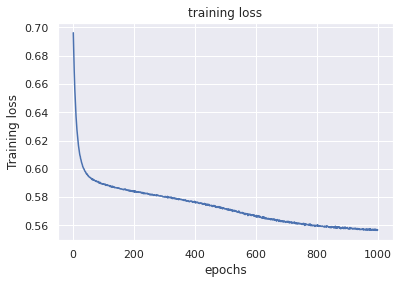

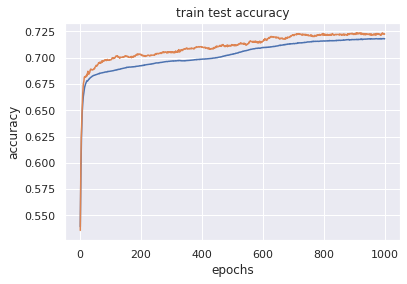

In [ ]:
epoch_graph=np.arange(1,1001)

plt.plot(epoch_graph,myloss)
plt.title('training loss')
plt.xlabel('epochs')
plt.ylabel('Training loss')
plt.show()



plt.plot(epoch_graph,mytrainaccuracy)

plt.plot(epoch_graph,mytestaccuracy)
plt.title('train test accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

Device used : cuda
epoch 0  | loss: 0.63653 | train_auc: 0.73581 | train_accuracy: 0.67634 | test_auc: 0.74416 | test_accuracy: 0.677   |  0:00:36s
epoch 1  | loss: 0.60532 | train_auc: 0.74677 | train_accuracy: 0.67608 | test_auc: 0.75523 | test_accuracy: 0.69352 |  0:01:02s
epoch 2  | loss: 0.60143 | train_auc: 0.74861 | train_accuracy: 0.68244 | test_auc: 0.74559 | test_accuracy: 0.68868 |  0:01:30s
epoch 3  | loss: 0.59844 | train_auc: 0.75249 | train_accuracy: 0.68955 | test_auc: 0.7486  | test_accuracy: 0.68264 |  0:01:56s
epoch 4  | loss: 0.59277 | train_auc: 0.75677 | train_accuracy: 0.68991 | test_auc: 0.75726 | test_accuracy: 0.70318 |  0:02:21s
epoch 5  | loss: 0.59253 | train_auc: 0.7504  | train_accuracy: 0.68537 | test_auc: 0.74786 | test_accuracy: 0.68304 |  0:02:46s
epoch 6  | loss: 0.59592 | train_auc: 0.75762 | train_accuracy: 0.69234 | test_auc: 0.75758 | test_accuracy: 0.67781 |  0:03:11s
epoch 7  | loss: 0.58978 | train_auc: 0.76128 | train_accuracy: 0.69512 | test

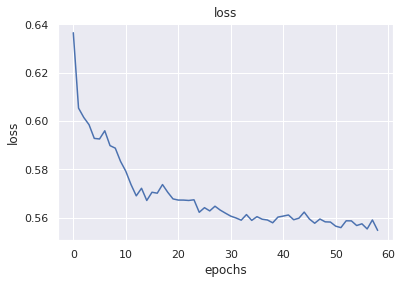

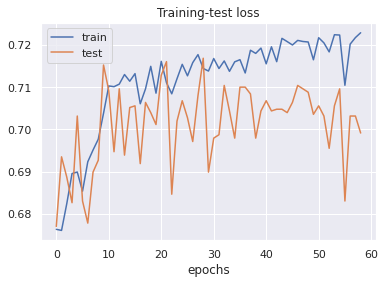

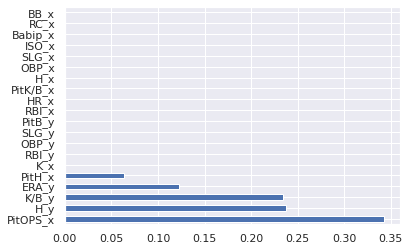

In [ ]:
!pip install pytorch-tabnet

y_train = train[y_cols]*1
y_test = test[y_cols]*1

X_train = train[x_cols]
X_test = test[x_cols]
X_train=X_train.values
y_train=y_train.values
X_test=X_test.values
y_test=y_test.values
y_test = np.squeeze(y_test)
y_train = np.squeeze(y_train)

import torch
import torch.nn as nn
from pytorch_tabnet.tab_model import TabNetClassifier

clf = TabNetClassifier(optimizer_fn=torch.optim.Adam,
                       optimizer_params=dict(lr=1e-2),
                       scheduler_params={"step_size":50,
                                         "gamma":0.9},
                       scheduler_fn=torch.optim.lr_scheduler.StepLR,
                       mask_type='sparsemax' # "sparsemax", entmax
                      )

max_epochs = 200

clf.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    eval_name=['train', 'test'],
    eval_metric=['auc','accuracy'],
    max_epochs=max_epochs , patience=30,
    batch_size=128, virtual_batch_size=32,
    num_workers=0,
    weights=1,
    drop_last=True,
)

preds_valid = clf.predict(X_test)
test_acc = accuracy_score(preds_valid, y_test)

print(f"BEST ACCURACY SCORE ON TEST SET : {test_acc}")

# plot losses
plt.plot(clf.history['loss'])
plt.title('loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

# plot accuracy
plt.plot(clf.history['train_accuracy'], label="train")
plt.plot(clf.history['test_accuracy'], label="test")
plt.title('Training-test loss')
plt.xlabel('epochs')
# plt.ylabel('Training-test loss')
plt.legend()
plt.show()
col_tmp = X_test.columns
# find and plot feature importance
y_pred = clf.predict(X_test)
clf.feature_importances_
feat_importances = pd.Series(clf.feature_importances_, index=col_tmp)
feat_importances.nlargest(20).plot(kind='barh')